## Introduction

This notebook summarizes and demonestrates all of the steps necessary for pre-processing and candidate extraction. As this is just for demonestration, all of the neccessary functions are developed in other files (please refer to helpers folder for detailed code)

### Imports

In [1]:
import sys
sys.path.append('..\\helpers')

import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw
from functools import reduce
from tqdm import tqdm

from pywt import dwt2
import math
from scipy import ndimage
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


# From helpers directory
from preprocessing import Preprocessor
from morphological_sifter import MorphologicalSifter
from segmentation import Segmentation
import demonestration as demo

import display


preprocessor = Preprocessor()
mms = MorphologicalSifter()
seg = Segmentation()


# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

<b>For the purpose of demonestration, sample images were uploaded in the same folder of this notebook. They include sample images (10 each) from positives, negatives, and ground truth files. This code is still excutable for all of the dataset, thus if more images were to added, please add them in the correct folder.</b>

### Dataset Validation

In [2]:
positives_path = '.\\dataset\\positives' # MUST USE double \\ for the rest of the code to work!
negatives_path = '.\\dataset\\negatives' # MUST USE double \\ for the rest of the code to work!
ground_truth_path = '.\\dataset\\ground_truth' # MUST USE double \\ for the rest of the code to work!

# Checking if folders are empty or not
assert demo.is_folder_not_empty(positives_path), "Positives folder is empty."
assert demo.is_folder_not_empty(negatives_path), "Negatives folder is empty."
assert demo.is_folder_not_empty(ground_truth_path), "Ground Truth folder is empty."

# Checking if the same images of positives are those in the ground truth folder
assert demo.are_folder_file_names_equal(positives_path, ground_truth_path), "File names in the folders are not equal."

The step above is cruital as it validates if all of the folders are in the right path. Those paths declared in the previous cell will be used in the next code blocks. So, please make sure to change or point to the correct paths if the validation above is not passing.

### Pre-processing

In the next section, we will demonestrate the pre-processing applied on the images as we implemented in this project. The pre-processing will handle export for the processed images automatically.

Please note that we pre-processs all of the dataset, thus the code below will be excuted multiple times for positives and negatives. There is a separate processing for the raw images (that are only used for evaluation with the extracted candidates), which is not done in this step.

2023-06-18 14:54:34.653 | INFO     | preprocessing:fit:167 - Started processing pipeline.
100%|██████████| 10/10 [00:06<00:00,  1.66it/s]
2023-06-18 14:54:40.697 | INFO     | preprocessing:fit:242 - Finished processing 10 files in approximately 6.044 seconds.


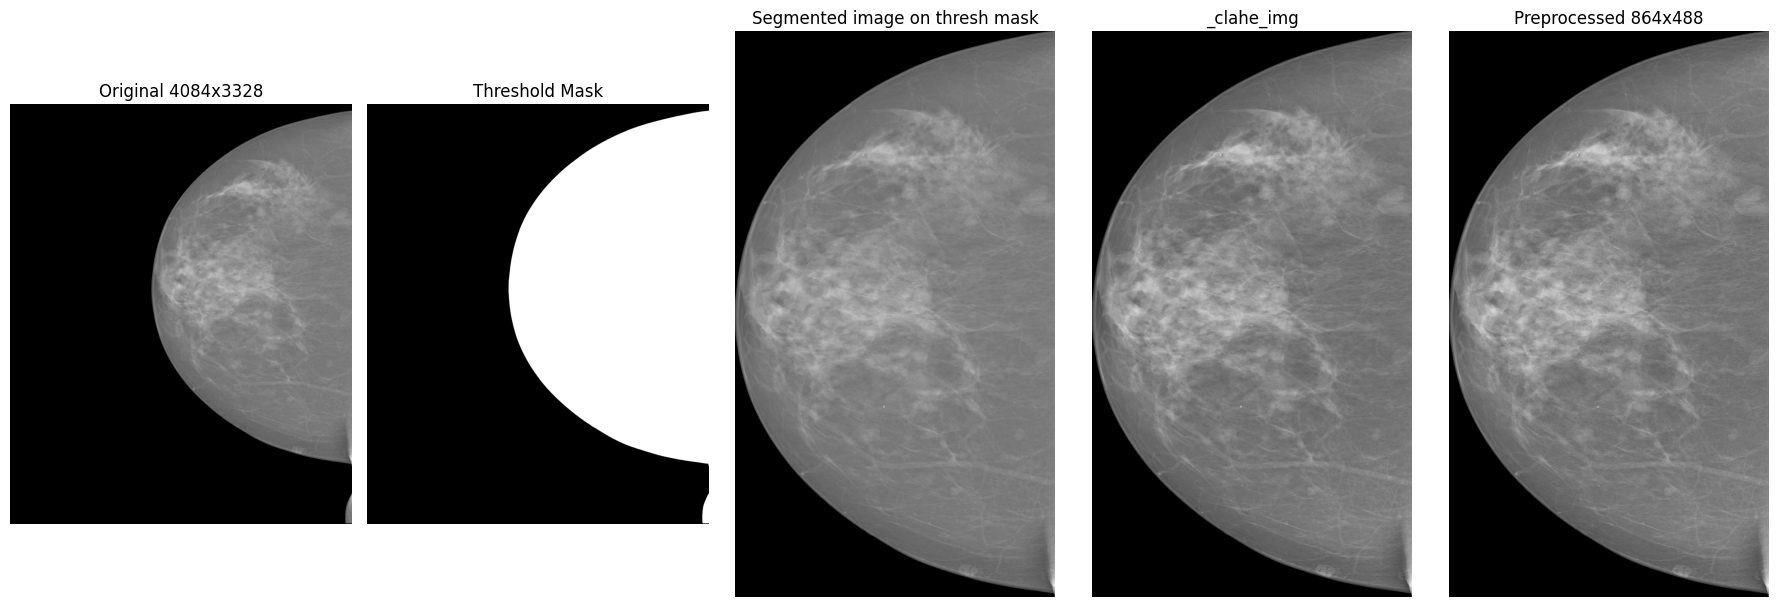

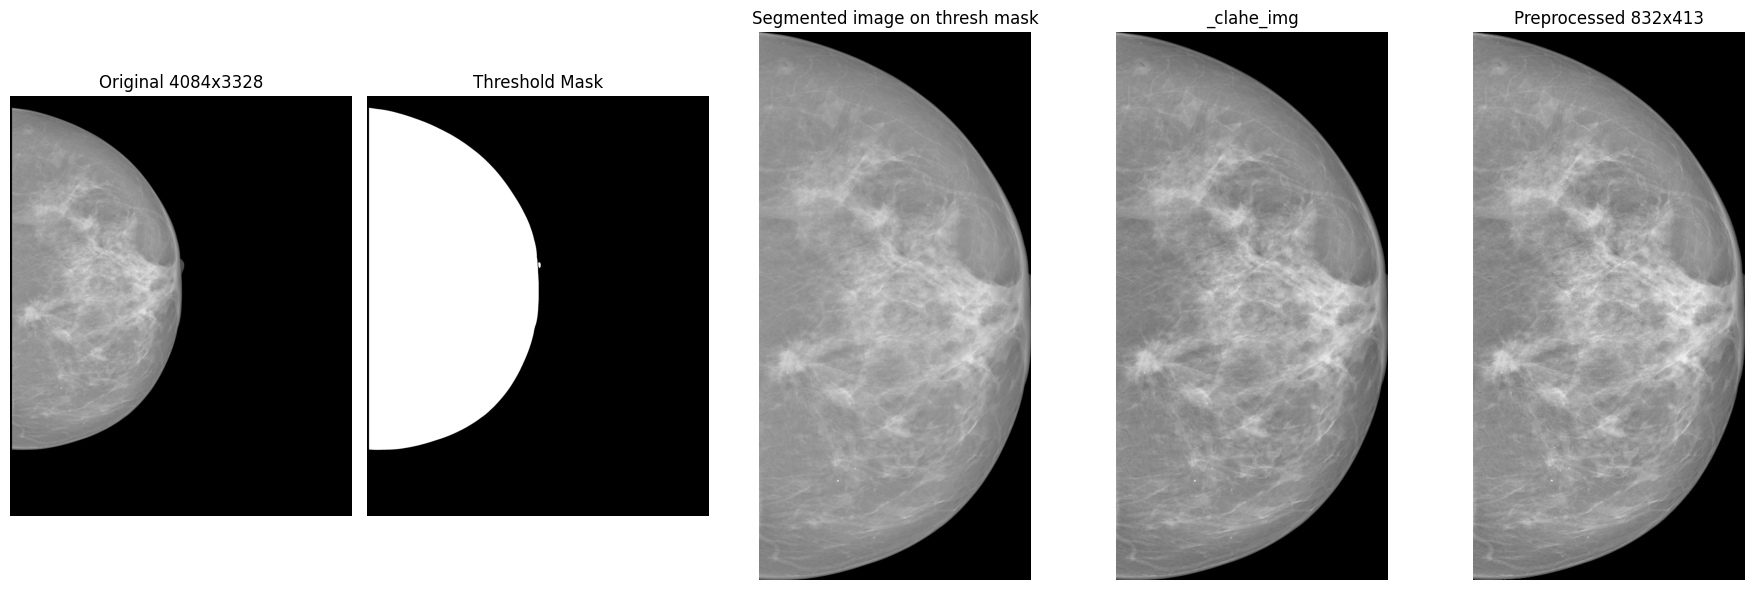

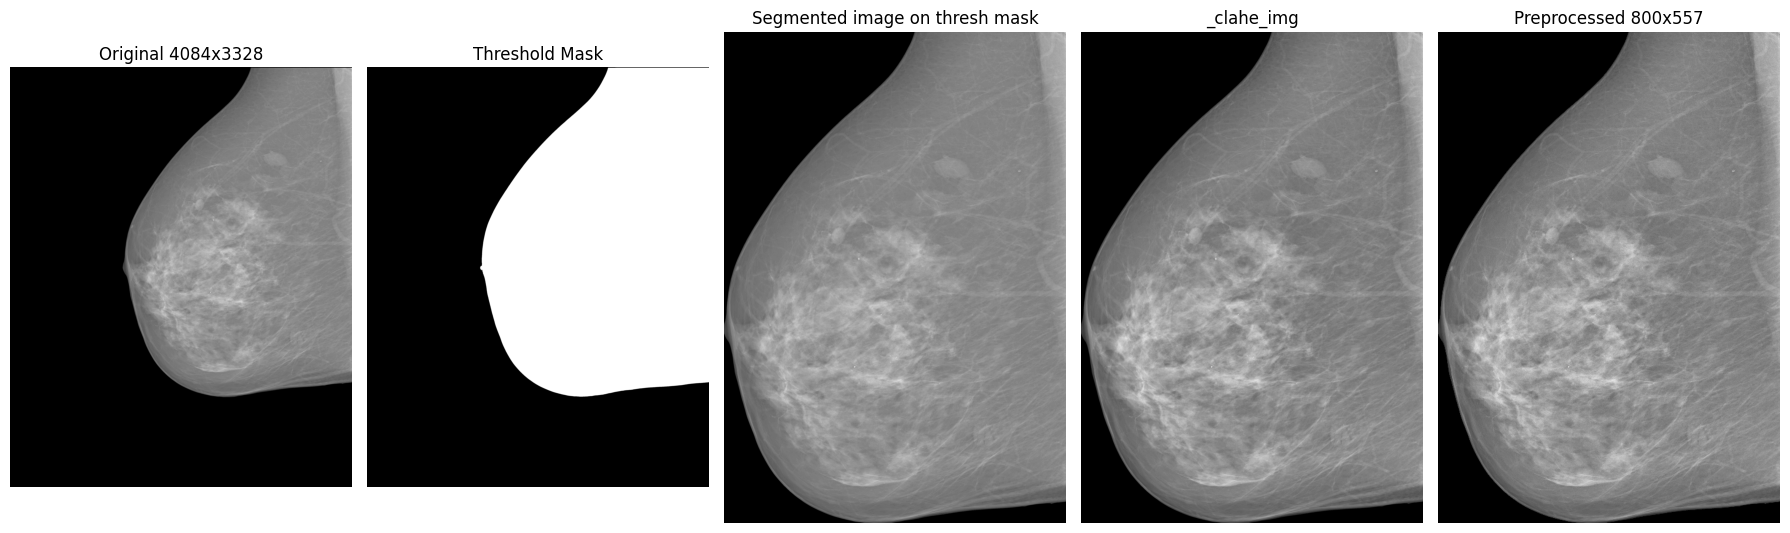

In [3]:
# As there are only 10 sample images in both positives and negatives, it is safe to run the code below to pre-process, 
# and visualize the result of the 10 samples.

# plot = True will visualise (Plot), change to False if you wish to not display the results in the notebook
# un-comment process_n=1 to only process 1 image, you can also process more than one togather by incrementing the number
# if you wish not to export, set the export_processed flag to False

preprocessor.fit(dataset_path= positives_path,
                 ground_truth_path = ground_truth_path,
#                  process_n=1, 
                 plot=True, 
                 export_processed=True)

In [ ]:
# # Pre-process the negatives
# preprocessor.fit(dataset_path= negatives_path,
#                  ground_truth_path = ground_truth_path,
# #                  process_n=1, 
#                  plot=True, 
#                  export_processed=True)

It is important to pre-process the raw images for evaluation (only cropping and resizing)! So we perform that in the next block. Those images are the same ones we have in the positives and negatives folders.

In [ ]:
all_images_path = ".\\dataset\\images" ## crop all 20 images (10 pos + 10 neg)
cropped_raw_dir = '.\\dataset\\cropped_raw'


if not os.path.isdir(cropped_raw_dir):
    os.makedirs(cropped_raw_dir)
    print(f"New directory created '{cropped_raw_dir}'")
    

for idx, file_name in tqdm(enumerate(os.listdir(all_images_path))):
    # read raw image 
    input_image = cv2.imread(
        os.path.join(
            all_images_path, 
            file_name
        ), cv2.IMREAD_UNCHANGED)
    
    # create file dir path
    file_dir = os.path.join(cropped_raw_dir, file_name)
    
    # crop raw image
    cropped_raw = preprocessor.crop_raw(input_image)
    
    # upsample, they were downsampled in the cropping to handle +- dimension approximation
    upsampled_raw = demo.upsample(cropped_raw)
    
    # export
    cv2.imwrite(file_dir, upsampled_raw.astype(np.uint16))

New directory created '.\dataset\cropped_raw'


20it [00:05,  3.96it/s]


At this step, you should have new folders created for the processed images, we validate the paths again as the first steps.
<b>It is important to run these validation blocks as they set the paths used in the next blocks!</b>

In [ ]:
processed_positives_path = '.\\dataset\\processed\\positives' # MUST USE double \\ for the rest of the code to work!
processed_ground_truth_path = '.\\dataset\\processed\\ground_truth' # MUST USE double \\ for the rest of the code to work!

# Checking if folders are empty or not
assert demo.is_folder_not_empty(processed_positives_path), "Processsed positives folder is empty."
assert demo.is_folder_not_empty(processed_ground_truth_path), "Processed ground Truth folder is empty."

# Checking if the same images of positives are those in the ground truth folder
assert demo.are_folder_file_names_equal(processed_positives_path, processed_ground_truth_path), "File names in the folders are not equal."

### Candidate Extraction

Visualizing a single image result for candidate extraction

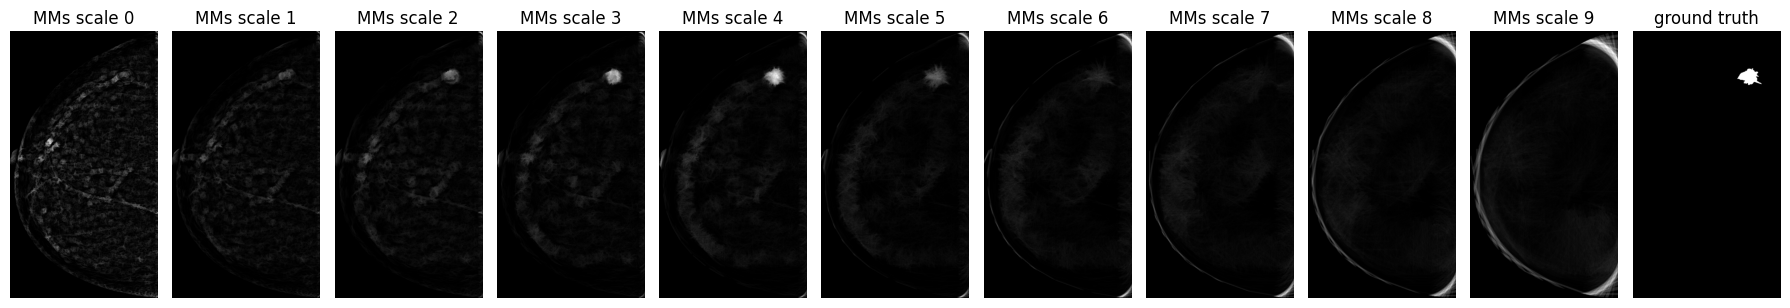

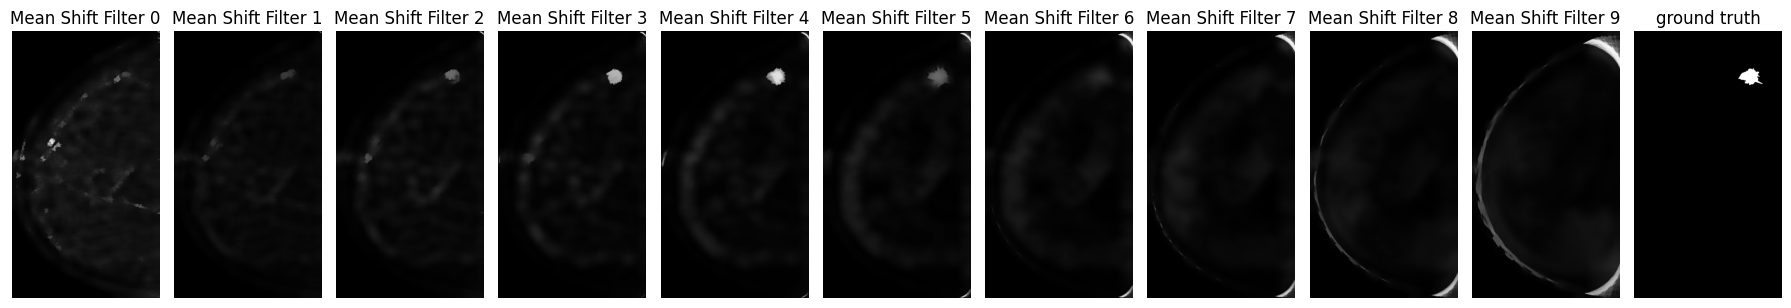

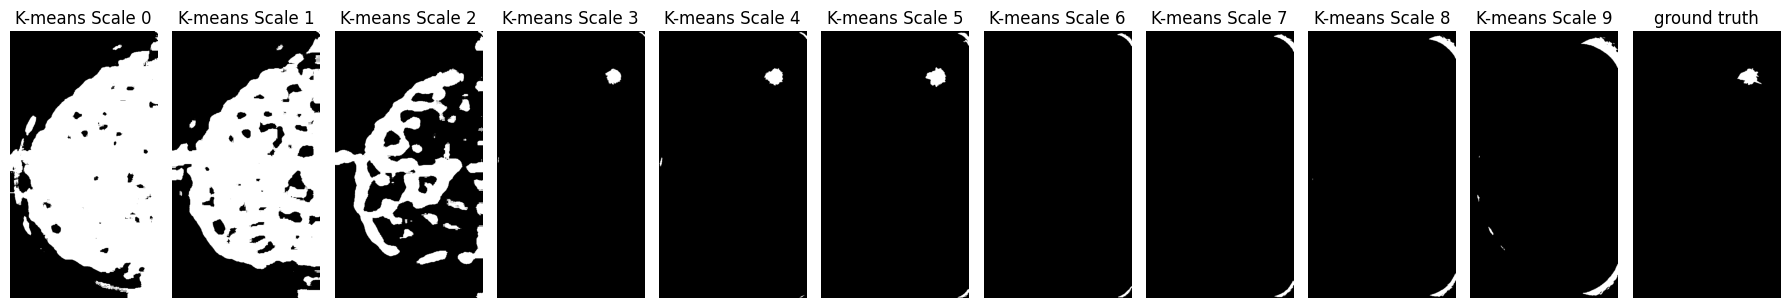

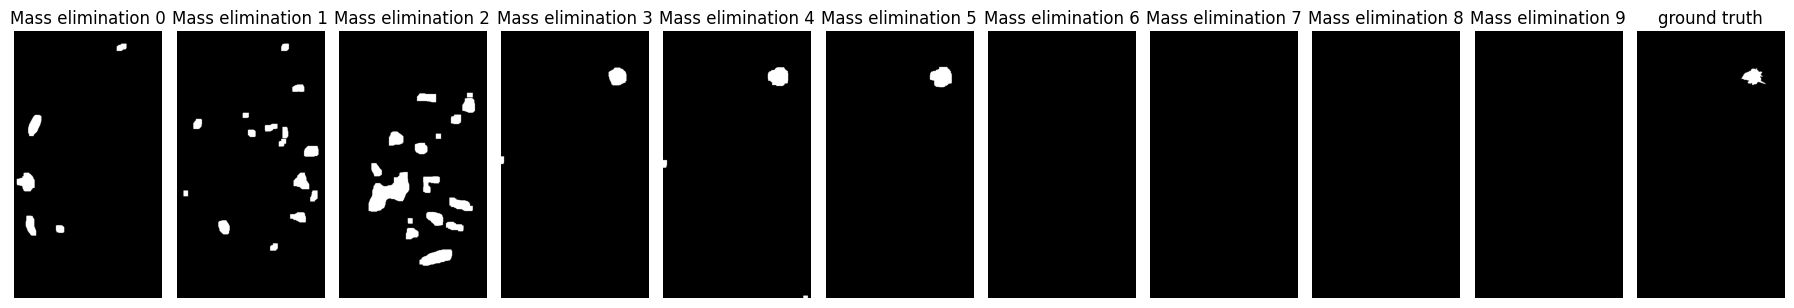

In [ ]:
image_input_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif' # positive sample image !

input_image = cv2.imread(
    os.path.join(
        processed_positives_path, 
        image_input_name
    ), cv2.IMREAD_UNCHANGED)

# we call the segmentation (candidate extraction) pipeline from the segmentation module
sifted_image, [mean_shifted_image_0, mean_shifted_image_1, mean_shifted_image_2, mean_shifted_image_3, mean_shifted_image_4, mean_shifted_image_5, mean_shifted_image_6, mean_shifted_image_7, mean_shifted_image_8, mean_shifted_image_9], \
            [kmean0, kmean1, kmean2, kmean3, kmean4, kmean5, kmean6, kmean7, kmean8, kmean9], \
            [mass0, mass1, mass2, mass3, mass4, mass5, mass6, mass7, mass8, mass9] = seg.pipeline(input_image)


# Plotting all 10 scales from multi-scale morphological sifting 
imgs = {
    "MMs scale 0": sifted_image[0],
    "MMs scale 1": sifted_image[1],
    "MMs scale 2": sifted_image[2],
    "MMs scale 3": sifted_image[3],
    "MMs scale 4": sifted_image[4],
    "MMs scale 5": sifted_image[5],
    "MMs scale 6": sifted_image[6],
    "MMs scale 7": sifted_image[7],
    "MMs scale 8": sifted_image[8],
    "MMs scale 9": sifted_image[9],
    "ground truth": cv2.imread(os.path.join(processed_ground_truth_path, image_input_name), cv2.IMREAD_UNCHANGED)
    }
display.plot_figures(imgs, 1, 11)

# Plotting all mean shift filter results from all scales
imgs = {
    "Mean Shift Filter 0": mean_shifted_image_0,
    "Mean Shift Filter 1": mean_shifted_image_1,
    "Mean Shift Filter 2": mean_shifted_image_2,
    "Mean Shift Filter 3": mean_shifted_image_3,
    "Mean Shift Filter 4": mean_shifted_image_4,
    "Mean Shift Filter 5": mean_shifted_image_5,
    "Mean Shift Filter 6": mean_shifted_image_6,
    "Mean Shift Filter 7": mean_shifted_image_7,
    "Mean Shift Filter 8": mean_shifted_image_8,
    "Mean Shift Filter 9": mean_shifted_image_9,
    "ground truth": cv2.imread(os.path.join(processed_ground_truth_path, image_input_name), cv2.IMREAD_UNCHANGED)
    }
display.plot_figures(imgs, 1, 11)

# Plotting all k-mean results from all scales
imgs = {
    "K-means Scale 0": kmean0,
    "K-means Scale 1": kmean1,
    "K-means Scale 2": kmean2,
    "K-means Scale 3": kmean3,
    "K-means Scale 4": kmean4,
    "K-means Scale 5": kmean5,
    "K-means Scale 6": kmean6,
    "K-means Scale 7": kmean7,
    "K-means Scale 8": kmean8,
    "K-means Scale 9": kmean9,
    "ground truth": cv2.imread(os.path.join(processed_ground_truth_path, image_input_name), cv2.IMREAD_UNCHANGED)
    } 
display.plot_figures(imgs, 1, 11)

# Plotting final segmentation results from all scales
imgs = {
    "Mass elimination 0": mass0,
    "Mass elimination 1": mass1,
    "Mass elimination 2": mass2,
    "Mass elimination 3": mass3,
    "Mass elimination 4": mass4,
    "Mass elimination 5": mass5,
    "Mass elimination 6": mass6,
    "Mass elimination 7": mass7,
    "Mass elimination 8": mass8,
    "Mass elimination 9": mass9,
    "ground truth": cv2.imread(os.path.join(processed_ground_truth_path, image_input_name), cv2.IMREAD_UNCHANGED)
    } 
display.plot_figures(imgs, 1, 11)

Now as we visualized an image, lets export them for further analysis.

In [ ]:
segmentation_output_dir = '.\\dataset\\output\\segmentation'

if not os.path.isdir(segmentation_output_dir):
    os.makedirs(segmentation_output_dir)
    print(f"New directory created '{segmentation_output_dir}'")
    

for idx, file_name in tqdm(enumerate(os.listdir(processed_positives_path))):
    input_image = cv2.imread(
        os.path.join(
            processed_positives_path, 
            file_name
        ), cv2.IMREAD_UNCHANGED)

    _, _, _, masses = seg.pipeline(input_image)
    
    for index, img in enumerate(masses):
        # the index will represent the scale
        file_dir = os.path.join(segmentation_output_dir, file_name.split('.tif')[0] + '_' + str(index) + '.tif')
        cv2.imwrite(file_dir, masses[index].astype(np.uint8))

New directory created '.\dataset\output\segmentation'


10it [01:22,  8.28s/it]


Just to have a better visualisation, let's compare the segmentation results and the ground truth on the cropped raw images!

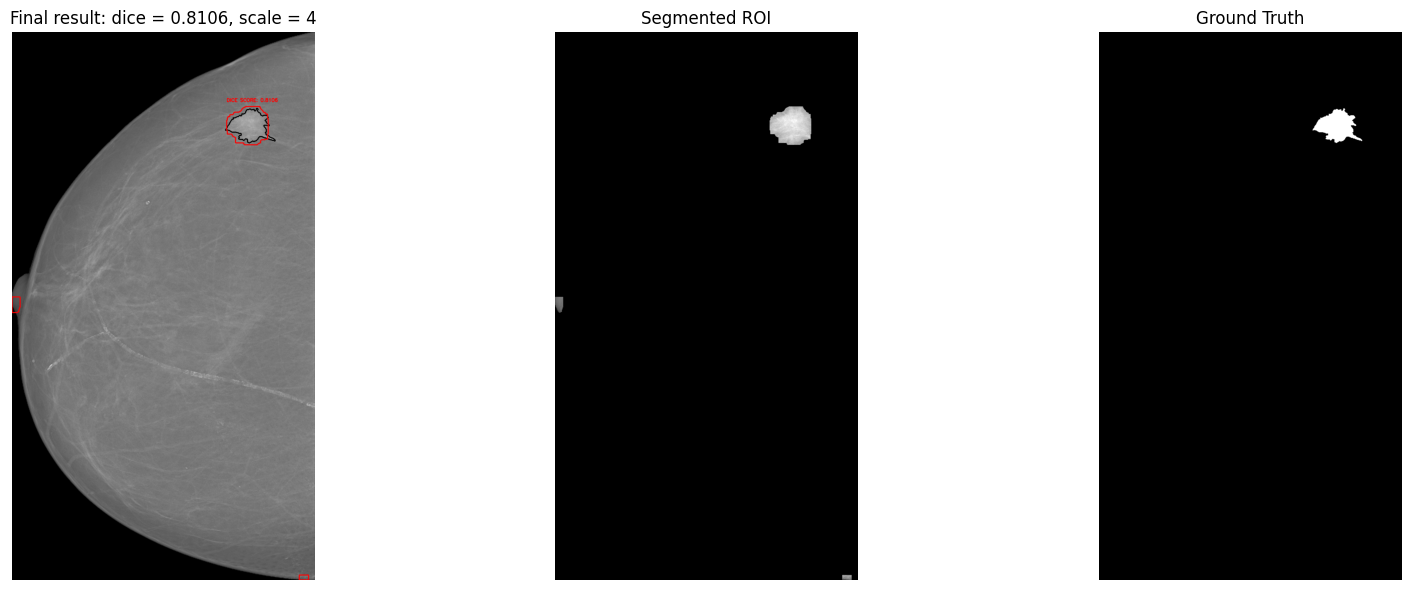

In [ ]:
# lets use the same image we visaulized before in the MMS visualisation, lets also visualise a single scale result
image_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON' # without .tif
mms_scale = 4 # you can choose from 0 - 9

gt_image   = cv2.imread(os.path.join(processed_ground_truth_path, image_name+'.tif'), cv2.IMREAD_GRAYSCALE)
segm_image = cv2.imread(os.path.join(segmentation_output_dir, image_name+f'_{mms_scale}'+'.tif'), cv2.IMREAD_GRAYSCALE)
raw_image  = cv2.imread(os.path.join(cropped_raw_dir, image_name+'.tif'), cv2.IMREAD_UNCHANGED)

gt_image   = demo.binarize(demo.upsample(gt_image))
segm_image = demo.binarize(demo.upsample(segm_image))

raw_image  = demo.convert_to_8bit(raw_image)

# Apply binary mask to the raw image
segmented_roi = cv2.bitwise_and(raw_image, segm_image)

raw_image  = cv2.cvtColor(raw_image, cv2.COLOR_GRAY2BGR)

# get the contours for both gt and seg
gt_contours, _  = cv2.findContours(gt_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
seg_contours, _ = cv2.findContours(segm_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the raw image
color_gt   = (0, 0, 0)   # black for gt
color_seg  = (255, 0, 0) # white for seg
cv2.drawContours(raw_image, gt_contours, -1, color_gt, thickness=6)
cv2.drawContours(raw_image, seg_contours, -1, color_seg, thickness=6)

# Display DICE score for the segmentation
for gt_cnt in gt_contours:
    max_dice = 0

    gt_candidate = np.zeros_like(gt_image)
    cv2.drawContours(gt_candidate, [gt_cnt], 0, (255, 255, 255), cv2.FILLED)                

    for seg_cnt in seg_contours:        
        mask_candidate = np.zeros_like(segm_image)
        cv2.drawContours(mask_candidate, [seg_cnt], 0, (255, 255, 255), cv2.FILLED)                

        intersection = cv2.bitwise_and(mask_candidate, gt_candidate)
        union = cv2.bitwise_or(mask_candidate, gt_candidate)

        intersection_pixels = cv2.countNonZero(intersection)
        union_pixels = cv2.countNonZero(union)

        dice_score = (2 * intersection_pixels) / (intersection_pixels + union_pixels)

        if dice_score > max_dice:
            max_dice = dice_score

            x, y, w, h = cv2.boundingRect(seg_cnt) 
    cv2.putText(raw_image, "DICE SCORE: " + str(round(max_dice, 4)), (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, color_seg, 4)

#will pop up cv2 image
# demo.show_image("Result obtained (Red:segmentation, Black:ground truth)", raw_image)


# uncomment this to plot the final result image only
# plt.figure(figsize=(12, 20))  # Set the figure size to 8 inches by 6 inches
# plt.imshow(raw_image)
# plt.xticks([]), plt.yticks([])
# plt.show()

# Plotting final segmentation results from all scales
imgs = {
    f"Final result: dice = {str(round(max_dice, 4))}, scale = {mms_scale}": raw_image,
    "Segmented ROI": segmented_roi,
    "Ground Truth": gt_image
    } 
display.plot_figures(imgs, 1, 3)

